In [63]:
!pip install numpy pandas corus pyldavis protobuf == 3.20.3 bigartm gensim matplotlib nltk razdel pymorphy3 -q

In [64]:
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz -q

In [17]:
import artm
import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from corus import load_lenta
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from hyperopt import STATUS_OK
from hyperopt import Trials, fmin, tpe
from hyperopt import hp
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
path = 'lenta-ru-news.csv.gz'
records = load_lenta(path)
data = [next(records).text for i in range(1000)]

In [6]:
nltk.download('stopwords')
stop_words = stopwords.words('russian')
additional_sw = 'мои оно мной мною мог могут мор мое мочь оба нам нами ними однако нему никуда наш нею неё наша наше наши очень отсюда вон вами ваш ваша ваше ваши весь всем всеми вся ими ею будем будете будешь буду будь будут кому кого которой которого которая которые который которых кем каждое каждая каждые каждый кажется та те тому собой тобой собою тобою тою хотеть хочешь свое свои твой своей своего своих твоя твоё сама сами теми само самом самому самой самого самим самими самих саму чему тебе такое такие также такая сих тех ту эта это этому туда этим этими этих абы аж ан благо буде вроде дабы едва ежели затем зато ибо итак кабы коли коль либо лишь нежели пока покамест покуда поскольку притом причем пускай пусть ровно сиречь словно также точно хотя чисто якобы '
pronouns = 'я мы ты вы он она оно они себя мой твой ваш наш свой его ее их то это тот этот такой таков столько весь всякий сам самый каждый любой иной другой кто что какой каков чей сколько никто ничто некого нечего никакой ничей нисколько кто-то кое-кто кто-нибудь кто-либо что-то кое-что что-нибудь что-либо какой-то какой-либо какой-нибудь некто нечто некоторый некий'
conjunctions = 'что чтобы как когда ибо пока будто словно если потому что оттого что так как так что лишь только как будто с тех пор как в связи с тем что для того чтобы кто как когда который какой где куда откуда'
digits = 'ноль один два три четыре пять шесть семь восемь девять десять одиннадцать двенадцать тринадцать четырнадцать пятнадцать шестнадцать семнадцать восемнадцать девятнадцать двадцать тридцать сорок пятьдесят шестьдесят семьдесят восемьдесят девяносто сто'
modal_words = 'вероятно возможно видимо по-видимому кажется наверное безусловно верно  действительно конечно несомненно разумеется'
particles = 'да так точно ну да не ни неужели ли разве а что ли что за то-то как ну и ведь даже еще ведь уже все все-таки просто прямо вон это вот как словно будто точно как будто вроде как бы именно как раз подлинно ровно лишь только хоть всего исключительно вряд ли едва ли'
prepositions = 'близ  вблизи  вдоль  вокруг  впереди  внутрь  внутри  возле  около  поверх  сверху  сверх  позади  сзади  сквозь  среди  прежде  мимо  вслед  согласно  подобно  навстречу  против  напротив  вопреки  после  кроме  вместе  вдали  наряду  совместно  согласно  нежели вроде от бишь до без аж тех раньше совсем только итак например из прямо ли следствие а поскольку благо пускай благодаря случае затем притом также связи время при чтоб просто того невзирая даром вместо точно покуда тогда зато ради ан буде прежде насчет раз причине тому так даже исходя коль кабы более ровно либо помимо как-то будто если словно лишь бы и не будь пор тоже разве чуть как хотя наряду потому пусть в равно между сверх ибо на судя то чтобы относительно или счет за но сравнению причем оттого есть когда уж ввиду тем для дабы чем хоть с вплоть скоро едва после той да вопреки ежели кроме сиречь же коли под абы несмотря все пока покамест паче прямо-таки перед что по вдруг якобы подобно'
evaluative = 'наиболее наименее лучший больший высший низший худший более менее'

stop_words.extend(additional_sw.split())
stop_words.extend(pronouns.split())
stop_words.extend(conjunctions.split())
stop_words.extend(digits.split())
stop_words.extend(modal_words.split())
stop_words.extend(particles.split())
stop_words.extend(prepositions.split())
stop_words.extend(evaluative.split())
stop_words = list(set(stop_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/slfdstrctd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
wnl = WordNetLemmatizer()


def process_words(texts):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in
             texts]  # lowercase, tokenize
    texts_out = []
    for sent in texts:
        texts_out.append([wnl.lemmatize(token) for token in sent])
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out


data_ready = process_words(data)
id2word = corpora.Dictionary(data_ready)
corpus = [id2word.doc2bow(text) for text in data_ready]
corpus[0]

[(0, 1),
 (1, 2),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 2),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 2),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 2),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 2),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 1)]

In [8]:
%%time

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=4,
    random_state=42,
    update_every=1,
    chunksize=10,
    passes=100,
    alpha='symmetric',
    iterations=150,
    per_word_topics=True,
)

print(lda_model.print_topics())

[(0, '0.008*"россии" + 0.005*"украины" + 0.005*"заявил" + 0.005*"ноября" + 0.004*"президент" + 0.004*"глава" + 0.004*"декабря" + 0.004*"сказал" + 0.003*"фсб" + 0.003*"страны"'), (1, '0.006*"декабря" + 0.006*"сообщает" + 0.003*"человек" + 0.003*"the" + 0.002*"словам" + 0.002*"франции" + 0.002*"сообщалось" + 0.002*"летний" + 0.002*"сотрудники" + 0.002*"загитова"'), (2, '0.010*"года" + 0.006*"году" + 0.006*"россии" + 0.004*"тысяч" + 0.004*"сша" + 0.004*"лет" + 0.004*"рублей" + 0.003*"декабря" + 0.003*"словам" + 0.003*"сообщает"'), (3, '0.003*"пользователи" + 0.002*"маркл" + 0.002*"фотографии" + 0.002*"меган" + 0.002*"новый" + 0.002*"издание" + 0.002*"гарри" + 0.002*"примерно" + 0.002*"некоторые" + 0.002*"group"')]
CPU times: user 1min 37s, sys: 0 ns, total: 1min 37s
Wall time: 1min 37s


In [19]:
CoherenceModel(model=lda_model, corpus=corpus, dictionary=lda_model.id2word, coherence='u_mass').get_coherence()

-5.301648599195436

In [11]:
lda_model.log_perplexity(corpus)

-10.468438855401457

In [70]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.180769  0.119939       1        1  38.026514
1      0.175283  0.088510       2        1  28.580854
0     -0.035125 -0.193201       3        1  21.081266
3      0.040610 -0.015247       4        1  12.311366, topic_info=         Term        Freq       Total Category  logprob  loglift
6        года  504.000000  504.000000  Default  30.0000  30.0000
36     россии  454.000000  454.000000  Default  29.0000  29.0000
549   украины  133.000000  133.000000  Default  28.0000  28.0000
53      тысяч  199.000000  199.000000  Default  27.0000  27.0000
1153      лет  179.000000  179.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1149  издание   25.412312  102.382428   Topic4  -6.3593   0.7012
172    ноябре   19.448296   83.761312   Topic4  -6.6267   0.6344
1562   тысячи   17.674344   53.060737   Topic4  -6.7224   0.9953
8        году   19.191197  342.995747   Topic4  -6.6400  -0.7886
191      сети   16.403521   39.161058   Topic4  -6.7970   1.2245

[217 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
20885      1  0.042726     apple
20885      4  0.939966     apple
1822       3  0.990819  facebook
2135       1  0.041494     group
2135       4  0.912861     group
...      ...       ...       ...
437        2  0.996695   франции
7068       1  0.085450       фсб
7068       3  0.907902       фсб
555        3  0.989607    церкви
57         2  0.991859   человек

[241 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

In [71]:
tokenized = [" ".join(x) for x in data_ready]

In [72]:
tokenized[0]

'вице премьер социальным вопросам татьяна голикова рассказала каких регионах россии зафиксирована высокая смертность рака сообщает риа новости словам голиковой чаще онкологические заболевания становились причиной смерти псковской тверской тульской орловской областях севастополе вице премьер напомнила главные факторы смертности россии рак болезни системы кровообращения начале года стало известно смертность онкологических заболеваний россиян снизилась впервые года данным росстата году рака умерли тысяч человек процента меньше годом ранее'

In [73]:
cv = CountVectorizer(max_features=1000, max_df=0.8, min_df=2, ngram_range=(1, 2))
n_wd = np.array(cv.fit_transform(tokenized).todense()).T
token_list = [i for i in cv.vocabulary_.keys()]
bv = artm.BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd, vocabulary=token_list)

/home/slfdstrctd/.local/lib/python3.11/site-packages/artm/batches_utils.py:234: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


In [74]:
token_list

['вице',
 'премьер',
 'рассказала',
 'каких',
 'регионах',
 'россии',
 'сообщает',
 'риа',
 'новости',
 'словам',
 'чаще',
 'причиной',
 'смерти',
 'тверской',
 'системы',
 'начале',
 'года',
 'стало',
 'известно',
 'россиян',
 'впервые',
 'данным',
 'году',
 'тысяч',
 'человек',
 'процента',
 'меньше',
 'ранее',
 'сообщает риа',
 'риа новости',
 'стало известно',
 'тысяч человек',
 'правил',
 'сообщил',
 'дмитрий',
 'итогам',
 'страны',
 'передает',
 'тасс',
 'свободы',
 'команды',
 'союз',
 'санкции',
 'российским',
 'мира',
 'полиция',
 'сборной',
 'хохфильцене',
 'вечером',
 'декабря',
 'написал',
 'александр',
 'логинов',
 'считают',
 'список',
 'обвинения',
 'назвал',
 'указал',
 'уголовное',
 'наказание',
 'передает тасс',
 'вечером декабря',
 'сотрудники',
 'сети',
 'instagram',
 'сообщается',
 'сайте',
 'таким',
 'образом',
 'признал',
 'пользователи',
 'эксперты',
 'назвали',
 'стал',
 'часто',
 'ноябре',
 'рейтинг',
 'самых',
 'стран',
 'уровень',
 'стала',
 'таким образом',

In [75]:
def objective(space):
    model = artm.ARTM(num_topics=space['num_topics'], dictionary=bv.dictionary, cache_theta=True)

    model.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=bv.dictionary))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
    model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=10))

    model.regularizers.add(
        artm.SmoothSparsePhiRegularizer(
            name='SparsePhi',
            tau=space['phi_tau']
        ),
    )
    model.regularizers.add(
        artm.SmoothSparseThetaRegularizer(
            name='SparseTheta',
            tau=space['theta_tau']
        )
    ),
    model.regularizers.add(
        artm.DecorrelatorPhiRegularizer(
            name='DecorrelatorPhi',
            tau=space['decorrelation_tau']
        ),
    )
    model.fit_offline(bv, num_collection_passes=30)

    perplexity_score = model.score_tracker["perplexity_score"].last_value
    print("Perplexity:", perplexity_score)
    return {'loss': perplexity_score, 'status': STATUS_OK}

In [76]:
topics_to_check = [10, 15, 20]

In [90]:
def run_hyperparams_search():
    space = {
        'num_topics': hp.choice('num_topics', topics_to_check),
        'phi_tau': hp.uniform('SparsePhi', -1, 1),
        'theta_tau': hp.uniform('SparseTheta', -1, 1),
        'decorrelation_tau': hp.uniform('DecorrelatorPhi', 1e+2, 1e+5),
    }

    trials = Trials()

    best_hyperparams = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=20,
        trials=trials,
    )
    return best_hyperparams

In [91]:
%%time
best = run_hyperparams_search()

Perplexity:                                           
373.9866943359375                                     
Perplexity:                                                                    
601.9484252929688                                                              
Perplexity:                                                                    
428.9548034667969                                                              
Perplexity:                                                                    
384.9872131347656                                                              
Perplexity:                                                                    
380.1702880859375                                                              
Perplexity:                                                                    
618.9788818359375                                                              
Perplexity:                                                                    
396.612701

In [92]:
def fit_model(seed=42):
    model = artm.ARTM(num_topics=topics_to_check[best['num_topics']], dictionary=bv.dictionary, cache_theta=True,
                      seed=seed)
    model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                          dictionary=bv.dictionary))

    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
    model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=10))

    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=best[
        'SparsePhi']))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=best[
        'SparseTheta']))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=best[
        'DecorrelatorPhi']))

    model.fit_offline(bv, num_collection_passes=30)
    return model

In [93]:
%%time
model = fit_model()

CPU times: user 1.09 s, sys: 120 ms, total: 1.21 s
Wall time: 1.25 s


## Perplexity

In [94]:
model.score_tracker["perplexity_score"].last_value

320.78765869140625

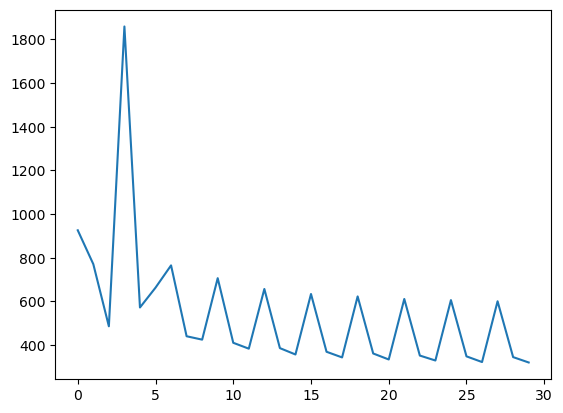

In [95]:
plt.plot(model.score_tracker["perplexity_score"].value);

In [96]:
model.score_tracker["sparsity_phi_score"].last_value

0.08349999785423279

## Sparsity

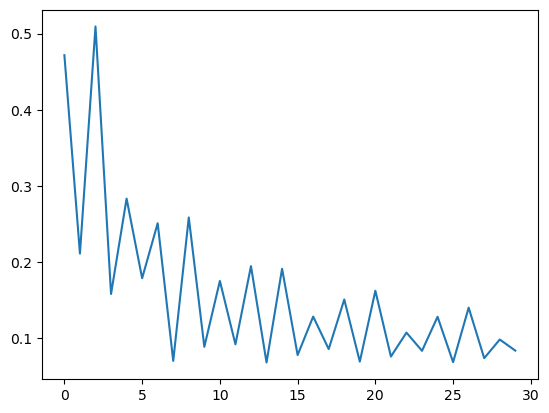

In [97]:
plt.plot(model.score_tracker["sparsity_phi_score"].value);

In [98]:
print(model.score_tracker["sparsity_theta_score"].last_value)

0.5429499745368958


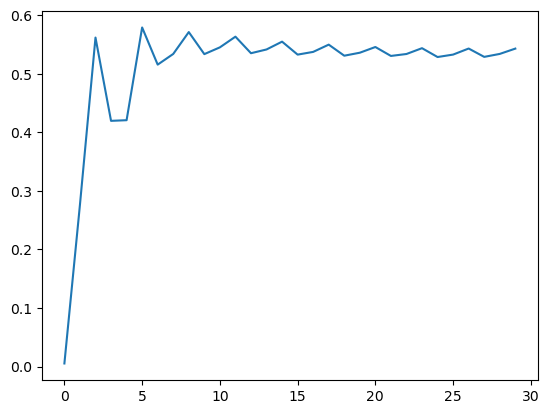

In [99]:
plt.plot(model.score_tracker["sparsity_theta_score"].value);

In [100]:
def prepare_vis_data():
    phi = model.get_phi()
    theta = model.get_theta().to_numpy().T
    theta = theta / theta.sum(axis=1, keepdims=1)
    data = {'topic_term_dists': phi.to_numpy().T,
            'doc_topic_dists': theta,
            'doc_lengths': n_wd.sum(axis=0).tolist(),
            'vocab': phi.T.columns,
            'term_frequency': n_wd.sum(axis=1).tolist()}
    return data

In [ ]:
pyLDAvis.enable_notebook()
model_data = prepare_vis_data()
model_vis = pyLDAvis.prepare(**model_data)

In [102]:
model_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.184181 -0.076801       1        1  13.999855
8      0.173271  0.082212       2        1  12.189047
17     0.209352  0.052994       3        1  11.831466
7      0.127561 -0.160751       4        1   8.030905
9      0.112942  0.114231       5        1   5.914658
12     0.009489 -0.078795       6        1   4.883417
15     0.060064  0.208454       7        1   4.352434
0      0.043473  0.000392       8        1   4.341938
18    -0.058838  0.039776       9        1   4.067954
2     -0.058727  0.196481      10        1   3.789867
16    -0.022474 -0.148196      11        1   3.717356
5      0.100373 -0.194892      12        1   3.515861
10     0.011051  0.051799      13        1   3.420526
11     0.026083 -0.062055      14        1   3.254274
1     -0.090637  0.076387      15        1   2.407500
14    -0.137620 -0.022193      16        1   2.394772
6     -0.185271 -0.129171      17        1   2.201164
13    -0.146641  0.080255      18        1   2.085054
4     -0.139805  0.011797      19        1   1.860204
3     -0.217828 -0.041924      20        1   1.741749, topic_info=                              Term        Freq       Total Category  logprob  \
343  (@default_class, заместитель)  188.000000  188.000000  Default  30.0000   
13       (@default_class, евгений)  289.000000  289.000000  Default  29.0000   
173        (@default_class, жизнь)  222.000000  222.000000  Default  28.0000   
28         (@default_class, семьи)  250.000000  250.000000  Default  27.0000   
90       (@default_class, которым)  151.000000  151.000000  Default  26.0000   
..                             ...         ...         ...      ...      ...   
545     (@default_class, интернет)    0.185404   30.143375  Topic20  -8.2756   
686       (@default_class, должен)    0.111652   27.845320  Topic20  -8.7828   
755    (@default_class, миллионов)    0.094545   22.565279  Topic20  -8.9491   
618          (@default_class, ряд)    0.088365   20.911317  Topic20  -9.0167   
683     (@default_class, участием)    0.128321   62.114675  Topic20  -8.6436   

     loglift  
343  30.0000  
13   29.0000  
173  28.0000  
28   27.0000  
90   26.0000  
..       ...  
545  -1.0409  
686  -1.4688  
755  -1.4248  
618  -1.4163  
683  -2.1319  

[723 rows x 6 columns], token_table=      Topic      Freq                           Term
term                                                
313      20  0.981213        (@default_class, daily)
9         1  0.970145     (@default_class, facebook)
9         4  0.011281     (@default_class, facebook)
9        14  0.022562     (@default_class, facebook)
50        4  0.940432       (@default_class, google)
...     ...       ...                            ...
889      11  1.008851       (@default_class, январе)
978       4  0.976669       (@default_class, января)
124       1  0.132395  (@default_class, января года)
124       4  0.321531  (@default_class, января года)
124       8  0.529580  (@default_class, января года)

[1103 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 9, 18, 8, 10, 13, 16, 1, 19, 3, 17, 6, 11, 12, 2, 15, 7, 14, 5, 4])